# 6. 텍스트와 시퀀스를 위한 딥러닝

텍스트(단어의 시퀀스 또는 문자의 시퀀스), 시계열 또는 일반적인 시퀀스
데이터를 <br>처리하는 기본적인 딥러닝 모델로는 순환 신경망(RNN)과 1D 컨브넷 두 가지가 있음

## 6.1 텍스트 데이터 다루기

### 6.1.3 모든 내용을 적용: 원본 텍스트에서 단어 임베딩까지

In [4]:
import os

imdb_dir = 'C:/datasets/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = list()
texts = list()

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == ".txt":
            f = open(os.path.join(dir_name, fname), encoding='utf8')
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            
            else:
                labels.append(1)


### 코드 6-9 IMDB 원본 데이터의 텍스트를 토큰화

In [43]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100
training_samples = 200
validation_samples = 10000
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

print (sequences)

word_index = tokenizer.word_index

data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(labels)
print('데이터 텐서의 크기:', data.shape)
print('레이블 텐서의 크기:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



### 코드 6-10 GloVe 단어 임베딩 파일 파싱

In [9]:
glove_dir = 'C:/datasets/'

embeddings_index = dict()

f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print ('%s개의 단어 벡터.' % len(embeddings_index))

400000개의 단어 벡터.


### 코드 6-11 GloVe 단어 임베딩 행렬 준비

In [10]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        
        if embedding_vector is not None:
            # 임베딩 인덱스에 없는 단어 모두 0
            embedding_matrix[i] = embedding_vector

### 코드 6-12 모델 정의

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          1000000   
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                320032    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


모델에 Glove 임베딩 로드

### 코드 6-13 사전 훈련된 단어 임베딩을 Embedding 층에 로드

In [13]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

### 코드 6-14 훈련과 평가

In [15]:
model.compile(optimizer='rmsprop',
             loss = 'binary_crossentropy',
             metrics=['acc'])

history = model.fit(x_train, y_train,
                   epochs=10,
                   batch_size=32,
                   validation_data=(x_val, y_val))

model.save_weights("C:/datasets/pre_trained_glove_model.h5")

Epoch 1/10
7/7 [==============================] - 0s 71ms/step - loss: 2.0367 - acc: 0.4900 - val_loss: 0.7138 - val_acc: 0.5235
Epoch 2/10
7/7 [==============================] - 0s 54ms/step - loss: 0.5055 - acc: 0.7500 - val_loss: 0.8242 - val_acc: 0.5058
Epoch 3/10
7/7 [==============================] - 0s 54ms/step - loss: 0.3975 - acc: 0.8450 - val_loss: 0.6864 - val_acc: 0.5651
Epoch 4/10
7/7 [==============================] - 0s 54ms/step - loss: 0.3986 - acc: 0.7850 - val_loss: 1.1585 - val_acc: 0.4990
Epoch 5/10
7/7 [==============================] - 0s 54ms/step - loss: 0.2066 - acc: 0.9400 - val_loss: 0.7197 - val_acc: 0.5603
Epoch 6/10
7/7 [==============================] - 0s 54ms/step - loss: 0.1460 - acc: 0.9800 - val_loss: 1.2706 - val_acc: 0.5071
Epoch 7/10
7/7 [==============================] - 0s 54ms/step - loss: 0.0856 - acc: 0.9950 - val_loss: 0.7597 - val_acc: 0.5719
Epoch 8/10
7/7 [==============================] - 0s 55ms/step - loss: 0.0413 - acc: 1.0000 - val

### 코드 6-15 결과 그래프

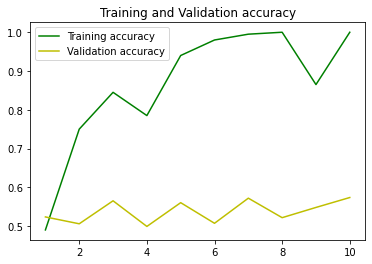

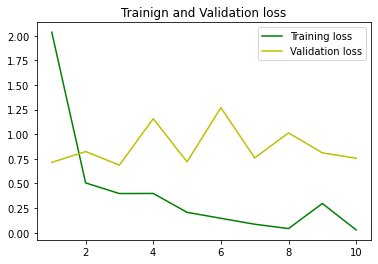

In [21]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'y', label = 'Validation accuracy')
plt.title("Training and Validation accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Trainign and Validation loss')
plt.legend()

plt.show()

### 코드 6-16 사전 훈련된 단어 임베딩을 사용하지 않고 같은 모델 훈련

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop',
             loss = 'binary_crossentropy',
             metrics=['acc'])

history = model.fit(x_train, y_train,
                   epochs=10,
                   batch_size=32,
                   validation_data=(x_val, y_val))

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_6 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 32)                320032    
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
7/7 [==============================] - 0s 66ms/step - loss: 0.6942 - acc: 0.4750 - val_loss: 0.6942 - val_acc: 0.5008
Epoch 2/10
7/7 [==============================] - 0s 57ms/step - loss: 0.4924 - acc: 1.0000 - val_loss: 0.7086 - 

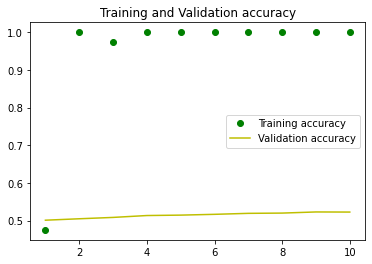

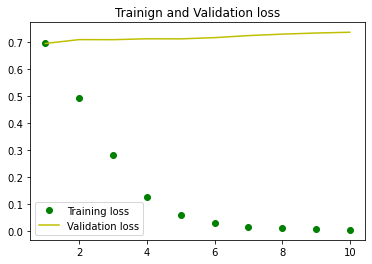

In [32]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'go', label='Training accuracy')
plt.plot(epochs, val_acc, 'y', label = 'Validation accuracy')
plt.title("Training and Validation accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'go', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Trainign and Validation loss')
plt.legend()

plt.show()

### 코드 6-17 테스트 데이터 토큰화

In [36]:
test_dir = os.path.join(imdb_dir, 'test')

labels = list()
texts = list()

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == ".txt":
            f = open(os.path.join(dir_name, fname), encoding="utf8")
            texts.append(f.read())
            f.close()
            if label_type == "neg":
                labels.append(0)
            else:
                labels.append(1)
                
sequences = tokenizer.texts_to_sequences(texts)
print (sequences)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



###  코드 6-18 테스트 세트에서 모델 평가

In [41]:
x_test = data[training_samples + validation_samples :]
y_test = labels[training_samples + validation_samples :]


model.load_weights('C:/datasets/pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

463/463 [==============================] - 1s 1ms/step - loss: 0.8201 - acc: 0.5222


[0.820133626461029, 0.522162139415741]